Convolutional Neural Network for Image Compression

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Conv2D,Flatten,MaxPooling2D,UpSampling2D,Reshape,Conv2DTranspose,LeakyReLU,BatchNormalization
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator #leggere immagini
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from matplotlib.gridspec import GridSpec





The dataset


In [12]:
# Download
import opendatasets as od
od.download("https://www.kaggle.com/datasets/prasunroy/natural-images")


In [8]:
# Make test set with one image for class
import shutil
import os
shutil.rmtree("natural-images/data")
names=os.listdir("natural-images/natural_images")
os.makedirs("natural-images/test")
for x in names:
  os.makedirs("natural-images/test/"+x)
  shutil.copy("natural-images/natural_images/"+x+"/"+x+"_0001.jpg","natural-images/test/"+ x)
  os.remove("natural-images/natural_images/"+x+"/"+x+"_0001.jpg")


In [9]:
batch_size=32
img_height=128
img_width=128
datagen= ImageDataGenerator(
    rescale=1./255,
     validation_split =0.2

)

train_ds = datagen.flow_from_directory("natural-images/natural_images/",
                                        target_size = (img_height, img_width),
                                        batch_size = batch_size,
                                        class_mode= "input",
                                       subset="training",
                                       seed=123,
                                        shuffle = True)

validation_ds = datagen.flow_from_directory("natural-images/natural_images/",
                                        target_size = (img_height, img_width),
                                        batch_size = batch_size,
                                        class_mode="input",
                                       subset="validation",
                                            seed=123,
                                        shuffle = False)
testgen= ImageDataGenerator(
    rescale=1./255
)

test_ds = testgen.flow_from_directory("natural-images/test/",
                                        target_size = (img_height, img_width),
                                        class_mode="input",
                                            seed=123,
                                        shuffle = False)

Found 5516 images belonging to 8 classes.
Found 1375 images belonging to 8 classes.
Found 8 images belonging to 8 classes.


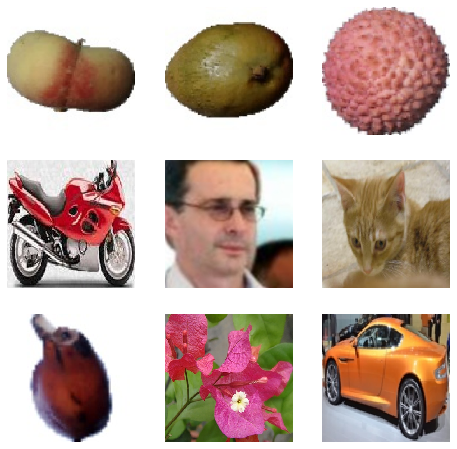

In [ ]:
plt.figure(figsize=(8,8))
for i in range(9):
      plt.subplot(330 + 1 + i)
      batch = train_ds.next()[0]*255
      image = batch[0].astype('uint8')
      plt.imshow(image)
      plt.axis("off")

plt.show()

The architecture

In [10]:
autoencoder = Sequential()
chanDim=-1
# Encoder
#Conv1
autoencoder.add(Conv2D(filters = 32, kernel_size=(3,3), input_shape=(img_height,img_width,3),padding='same', name='enc_conv1'))
autoencoder.add(LeakyReLU())
autoencoder.add(BatchNormalization(axis=chanDim))
autoencoder.add(MaxPooling2D(pool_size=(2,2),name='enc_pool1'))


#Conv2
autoencoder.add(Conv2D(filters = 16, kernel_size=(3,3),padding='same', name='enc_conv2'))
autoencoder.add(LeakyReLU())
autoencoder.add(BatchNormalization(axis=chanDim))
autoencoder.add(MaxPooling2D(pool_size=(2,2),name='enc_pool2'))


# feature latenti
autoencoder.add(Flatten(name="flatten"))


# Decoder
autoencoder.add(Reshape((32,32,16)))

#Conv1
autoencoder.add(Conv2DTranspose(filters = 16, kernel_size=(3,3), strides=2, padding='same', name="dec_conv1"))
autoencoder.add(LeakyReLU(alpha=0.5))
autoencoder.add(BatchNormalization(axis=chanDim))
autoencoder.add(UpSampling2D(size=(2,2)))


#Conv2
autoencoder.add(Conv2DTranspose(filters = 32, kernel_size=(3,3), padding='same', name="dec_conv2"))
autoencoder.add(LeakyReLU(alpha=0.5))
autoencoder.add(BatchNormalization(axis=chanDim))



autoencoder.add(Conv2D(filters = 3, kernel_size=(3,3), activation='sigmoid', padding='same'))






In [11]:
autoencoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 enc_conv1 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 32)      0         
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 32)     128       
 ormalization)                                                   
                                                                 
 enc_pool1 (MaxPooling2D)    (None, 64, 64, 32)        0         
                                                                 
 enc_conv2 (Conv2D)          (None, 64, 64, 16)        4624      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 64, 16)        0         
                                                        

In [12]:


def FrobeniusLoss(y_true, y_pred):
    """
    A loss that evaluates the pixel-to-pixel quadratic difference
    """
    heat_difference = tf.math.squared_difference(y_true,y_pred)
    hm_loss = tf.sqrt(tf.reduce_sum(heat_difference))
    return hm_loss



In [13]:
autoencoder.compile(optimizer="adam", loss=FrobeniusLoss)

In [13]:
# To train again
checkpoint = ModelCheckpoint("weights/new_weights_name.hdf5", monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
early_stop = EarlyStopping(monitor='loss', patience=3)
history = autoencoder.fit(train_ds, batch_size=batch_size,epochs=100,callbacks=callbacks_list, validation_data=validation_ds,validation_steps=10)


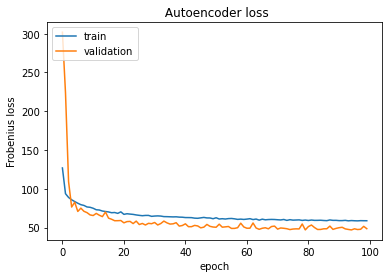

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(' Autoencoder loss')
plt.ylabel('Frobenius loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [14]:
# To load existing weights
autoencoder.load_weights("weights/autoencoder_w_frobenius.hdf5")


In [15]:
# Get the Encoder block of the model
encoder = Model(inputs = autoencoder.input, outputs = autoencoder.get_layer('flatten').output)
encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 enc_conv1_input (InputLayer  [(None, 128, 128, 3)]    0         
 )                                                               
                                                                 
 enc_conv1 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 32)      0         
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 32)     128       
 ormalization)                                                   
                                                                 
 enc_pool1 (MaxPooling2D)    (None, 64, 64, 32)        0         
                                                                 
 enc_conv2 (Conv2D)          (None, 64, 64, 16)        4624  

1/1 [==============================] - 1s 1s/step
Frobenius  8.911514282226562
1/1 [==============================] - 0s 33ms/step
Frobenius  8.313274383544922
1/1 [==============================] - 0s 26ms/step
Frobenius  6.416881561279297
Average Test Loss: 7.880556742350261


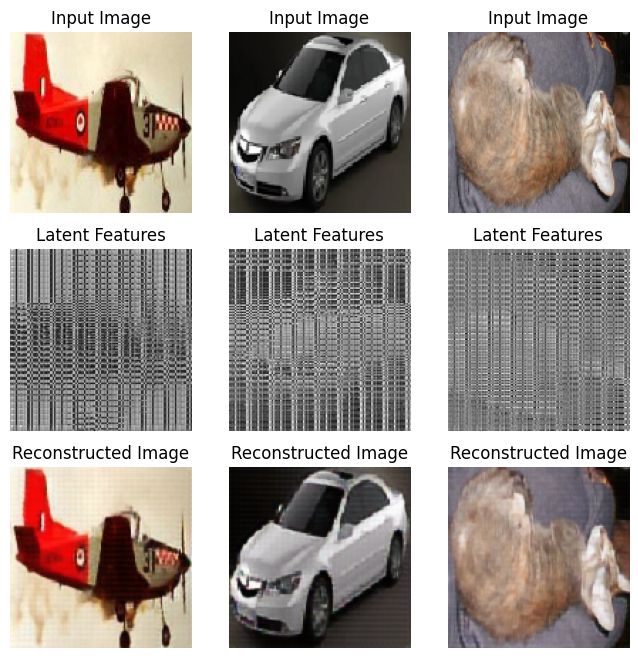

In [16]:
fig = plt.figure(figsize=(8, 8))
n=3
sum=0
for i in range(n):
      batch = test_ds.next()[0]
      image = batch[i]
      gs = GridSpec(nrows=3, ncols=n)
      ax0 = fig.add_subplot(gs[0, i])
      ax0.title.set_text("Input Image")
      ax0.axis("off")
      ax0.imshow(image)
      img=tf.expand_dims(image, 0)
      coded_test_images = encoder.predict(img)
      decoded_test_images = autoencoder.predict(img)
      ax1 = fig.add_subplot(gs[1, i])
      ax1.axis("off")
      ax1.title.set_text("Latent Features")
      ax1.imshow(coded_test_images.reshape(128,128), cmap='gray')
      ax2 = fig.add_subplot(gs[2, i])
      ax2.axis("off")
      ax2.title.set_text("Reconstructed Image")
      ax2.imshow(decoded_test_images.reshape(128,128,3))
      print("Frobenius ",float(FrobeniusLoss(image,decoded_test_images)))

      sum+= float(FrobeniusLoss(image,decoded_test_images))

print("Average Test Loss:", sum/n)




In [18]:
# To store the orginal image we need 128*128*3 values
# To store the "approximate" image just store the encifcation of the latent features of the encoder i.e. 32*32*16 values

n0= 128*128*3
n1= 32*32*16

print("Fraction of information used in encoding phase:", round(n1/n0*100,2))
print("Compression factor: ", round(n0/n1))


Fraction of information used in encoding phase: 33.33
Compression factor:  3


10-Fold Cross Validation

In [ ]:
batch_size=32
img_height=128
img_width=128
datagen= ImageDataGenerator(
    rescale=1./255

)

train_ds = datagen.flow_from_directory("/content/drive/MyDrive/Colab Notebooks/natural-images/natural_images",
                                        target_size = (img_height, img_width),
                                        batch_size = batch_size,
                                        class_mode= None,
                                       subset="training",
                                       seed=123,
                                        shuffle = True)

Found 6891 images belonging to 8 classes.


In [ ]:
def generator_to_array(data_generator):
    data_list = []
    batch_index = 0

    while batch_index <= data_generator.batch_index:
        batch = data_generator.next()
        for data in batch:
            data_list.append(data)
        batch_index = batch_index + 1

    # now, data_array is the numeric data of whole images
    data_array = np.asarray(data_list)
    return data_array

In [ ]:
k_train = generator_to_array(train_ds)

In [19]:
from tensorflow.python.keras.backend  import set_session,clear_session,get_session
import gc

# function to free up space at each iteration of cross-validation
def reset_keras():
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

    try:
        del model
    except:
        pass

    print("Reset Keras ",gc.collect())

    config = tf.compat.v1.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    set_session(tf.compat.v1.Session(config=config))

In [ ]:
from sklearn.model_selection import ParameterGrid
# we want to tune the size fo kernel filter in the encoding and decoding phase
param_grid = {'kernel_size_enc': [3,5,9],'kernel_size_dec': [3,5,9]}
expanded_grid = ParameterGrid(param_grid)

In [ ]:
# number of combination
len(expanded_grid)

9

In [ ]:

def create_model(expanded_grid):




    model = Sequential()
    # Encoder
    #Conv1
    model.add(Conv2D(filters = 32, kernel_size=expanded_grid["kernel_size_enc"], input_shape=(img_height,img_width,3),padding='same', name='enc_conv1'))
    model.add(LeakyReLU())
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2,2),name='enc_pool1'))


    #Conv2
    model.add(Conv2D(filters = 16, kernel_size=expanded_grid["kernel_size_enc"],padding='same', name='enc_conv2'))
    model.add(LeakyReLU())
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2,2),name='enc_pool2'))


    # feature latenti
    model.add(Flatten(name="flatten"))
    
    # Decoder
    model.add(Reshape((32,32,16)))

    #Conv1
    model.add(Conv2DTranspose(filters = 16, kernel_size=expanded_grid["kernel_size_dec"], strides=2, padding='same', name="dec_conv1"))
    model.add(LeakyReLU())
    model.add(BatchNormalization(axis=chanDim))
    model.add(UpSampling2D(size=(2,2)))


    #Conv2
    model.add(Conv2DTranspose(filters = 32, kernel_size=expanded_grid["kernel_size_dec"], padding='same', name="dec_conv2"))
    model.add(LeakyReLU())
    model.add(BatchNormalization(axis=chanDim))



    model.add(Conv2D(filters = 3, kernel_size=expanded_grid["kernel_size_dec"], activation='sigmoid', padding='same'))

    optimizer=tf.keras.optimizers.Adam()

    model.compile(optimizer=optimizer, loss=FrobeniusLoss)
    return model

In [ ]:
import csv

header = [ 'kernel_size_enc', 'kernel_size_dec', "CV Loss"]


with open('result.csv', 'w') as f:
    writer = csv.writer(f)
    # write the header
    writer.writerow(header)


In [14]:
# To do 10-Fold Cross Validation again
import csv

reset_keras()
from sklearn.model_selection import KFold
kfold = KFold(n_splits=10, shuffle=True)
chanDim=-1
res ={'10FoldCV-Loss': [],
 'kernel_size_dec': [],
 'kernel_size_enc': []}
for i in range(len(expanded_grid)):
        print(expanded_grid[i])
        fold_no=1
        loss_per_fold=[]
        for train, test in kfold.split(k_train, k_train):
            model = create_model(expanded_grid[i])


            # Generate a print
            print('------------------------------------------------------------------------')
            print(f'Training for fold {fold_no} ...')
            # Fit data to model
            history = model.fit(k_train[train], k_train[train],
                      batch_size=batch_size,
                      epochs=50,
                      verbose=1,
                               steps_per_epoch=20)

            # Generate generalization metrics
            scores = model.evaluate(k_train[test], k_train[test], verbose=0)
            loss_per_fold.append(scores)

            # Increase fold number
            fold_no = fold_no + 1
            reset_keras()

        res["kernel_size_enc"].append(expanded_grid[i]["kernel_size_enc"])
        res["kernel_size_dec"].append(expanded_grid[i]["kernel_size_dec"])
        res["10FoldCV-Loss"].append(round(sum(loss_per_fold)/10,3))
        with open('/content/drive/MyDrive/Colab Notebooks/result.csv', 'a') as f:
                writer = csv.writer(f)
                writer.writerow([res["kernel_size_enc"][i],res["kernel_size_dec"][i],res["10FoldCV-Loss"][i]])
                print (i+1, "/", len(expanded_grid))





In [6]:
# Exsisting results
import pandas as pd
df = pd.read_csv("utils/result.csv")
df

,kernel_size_enc,kernel_size_dec,CV Loss
0,3,3,79.165
1,5,3,80.457
2,9,3,81.128
3,3,5,79.204
4,5,5,82.235
5,9,5,86.431
6,3,9,80.380
7,5,9,82.830
8,9,9,89.806


In [11]:
print("The best configuration is")
print(df.loc[df["CV Loss"]==min(df["CV Loss"])])

The best configuration is
   kernel_size_enc  kernel_size_dec  CV Loss
0                3                3   79.165


Denoising Autoencoder

In [ ]:
def add_gaussian_noise(data, mean=0, std=1):
    """
    Function to make noise images
    """
    mean = (mean, mean, mean)
    std = (std, std, std)
    row, col, channel = data.shape
    noise = np.random.normal(mean, std, (row, col, channel)).astype('uint8')
    return data+noise


datagen= ImageDataGenerator(
    rescale=1./255,
     validation_split =0.2

)

train_ds = datagen.flow_from_directory("natural-images/natural_images/",
                                        target_size = (img_height, img_width),
                                        batch_size = batch_size,
                                        class_mode= None,
                                       subset="training",
                                       seed=123,
                                        shuffle = False)

validation_ds = datagen.flow_from_directory("natural-images/natural_images/",
                                        target_size = (img_height, img_width),
                                        batch_size =batch_size,
                                        class_mode=None,
                                       subset="validation",
                                            seed=123,
                                        shuffle = False)
testgen= ImageDataGenerator(
    rescale=1./255
)

test_ds = testgen.flow_from_directory("natural-images/test/",
                                        target_size = (img_height, img_width),
                                        class_mode=None,
                                            seed=123,
                                        shuffle = False)




datagen= ImageDataGenerator(
    rescale=1./255,
     validation_split =0.2,
    preprocessing_function= add_gaussian_noise

)

noise_train = datagen.flow_from_directory("natural-images/natural_images/",
                                        target_size = (img_height, img_width),
                                        batch_size = batch_size,
                                        class_mode=None,
                                       subset="training",
                                       seed=123,
                                        shuffle = False)

noise_validation = datagen.flow_from_directory("natural-images/natural_images/",
                                        target_size = (img_height, img_width),
                                        batch_size = batch_size,
                                        class_mode=None,
                                       subset="validation",
                                            seed=123,
                                        shuffle = False)


testgen= ImageDataGenerator(
    rescale=1./255 ,
     preprocessing_function= add_gaussian_noise
)

noise_test = testgen.flow_from_directory("natural-images/test/",
                                        target_size = (img_height, img_width),
                                        class_mode=None,
                                        shuffle = False)



Found 5523 images belonging to 8 classes.
Found 1376 images belonging to 8 classes.
Found 8 images belonging to 8 classes.
Found 5523 images belonging to 8 classes.
Found 1376 images belonging to 8 classes.
Found 8 images belonging to 8 classes.


In [ ]:
train_array= generator_to_array(train_ds)
noise_array= generator_to_array(noise_train)
validation_array= generator_to_array(validation_ds)
validation_narray= generator_to_array(noise_validation)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


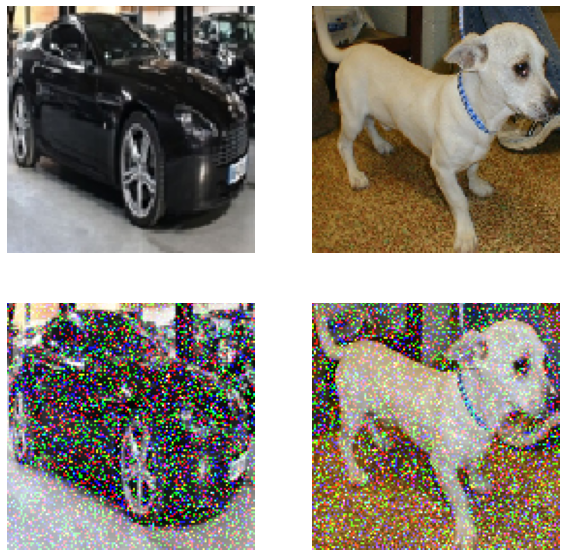

In [ ]:
fig = plt.figure(figsize=(8, 8))
n=2
for i in range(n):
      idx = np.random.randint(0,5522)
      image = train_array[idx]
      n_img = noise_array[idx]
      gs = GridSpec(nrows=2, ncols=n)
      ax0 = fig.add_subplot(gs[0, i])
      ax0.axis("off")
      ax0.imshow(image)
      ax1 = fig.add_subplot(gs[1, i])
      ax1.axis("off")
      ax1.imshow(n_img)


In [ ]:
with open("utils/autoencoder.json") as json_file:
    json_saved_model = json_file.read()
denoising_autoencoder = tf.keras.models.model_from_json(json_saved_model)
denoising_autoencoder.summary()
denoising_autoencoder.compile(optimizer="adam", loss=FrobeniusLoss)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 enc_conv1 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 128, 128, 32)      0         
                                                                 
 batch_normalization_8 (Batc  (None, 128, 128, 32)     128       
 hNormalization)                                                 
                                                                 
 enc_pool1 (MaxPooling2D)    (None, 64, 64, 32)        0         
                                                                 
 enc_conv2 (Conv2D)          (None, 64, 64, 16)        4624      
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 64, 64, 16)        0         
                                                      

In [ ]:
# To load exsisting weights
denoising_autoencoder.load_weights("weights/den_autoencoder.hdf5")
d_encoder = Model(inputs = denoising_autoencoder.input, outputs = denoising_autoencoder.get_layer('flatten').output)


In [15]:
# To train again
d_checkpoint = ModelCheckpoint("den_autoencoder.hdf5", monitor='loss', verbose=1, save_best_only=True, mode='min')
d_callbacks_list = [d_checkpoint]
history_denoise = denoising_autoencoder.fit(x=noise_array,y=train_array,epochs=100,callbacks=d_callbacks_list, validation_data=(validation_narray,validation_array),shuffle=True)


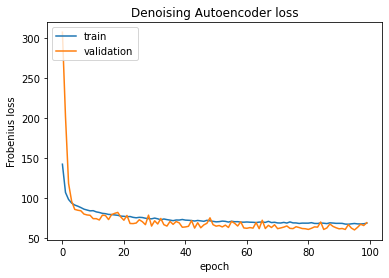

In [ ]:
# summarize history for loss
plt.plot(history_denoise.history['loss'])
plt.plot(history_denoise.history['val_loss'])
plt.title('Denoising Autoencoder loss')
plt.ylabel('Frobenius loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
test_array = generator_to_array(test_ds)
noise_array_test = generator_to_array(noise_test)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Frobenius Loss 13.107315063476562


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Frobenius Loss 14.496633529663086


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Frobenius Loss 12.606243133544922


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Frobenius Loss 12.54271125793457


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Frobenius Loss 13.404525756835938
Frobenius Loss 5.567348480224609
Average Test Loss: 11.954129536946615


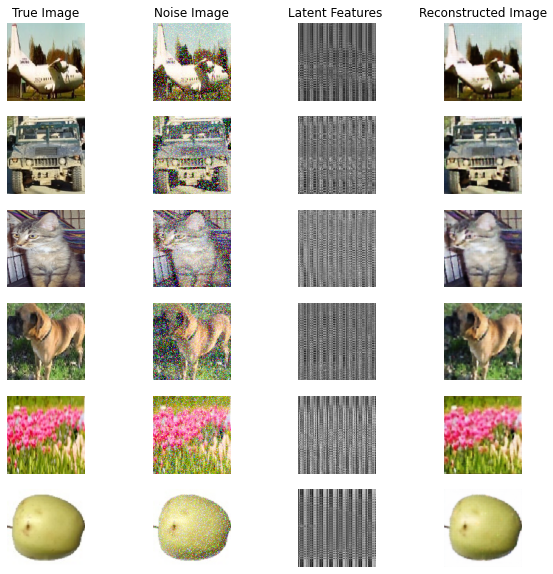

In [ ]:
fig = plt.figure(figsize=(10, 10))
n=6
sum=0
for i in range(n):
      image = test_array[i]
      n_image = noise_array_test[i]
      gs = GridSpec(nrows=n, ncols=4)
      ax0 = fig.add_subplot(gs[i, 1])
      ax0.axis("off")
      ax0.imshow(n_image)
      img=tf.expand_dims(n_image, 0)
      coded_test_images = d_encoder.predict(img)
      decoded_test_images = denoising_autoencoder.predict(img)
      ax1 = fig.add_subplot(gs[i,2])
      ax1.axis("off")
      ax1.imshow(coded_test_images.reshape(128,128), cmap='gray')
      ax2 = fig.add_subplot(gs[i, 3])
      ax2.axis("off")
      ax2.imshow(decoded_test_images.reshape(128,128,3))
      ax3 = fig.add_subplot(gs[i, 0])
      ax3.axis("off")
      ax3.imshow(image)
      if i==0:
            ax0.title.set_text('Noise Image')

            ax1.title.set_text('Latent Features ')

            ax2.title.set_text('Reconstructed Image')

            ax3.title.set_text('True Image')

      print("Frobenius Loss",float(FrobeniusLoss(image,decoded_test_images)))

      sum+= float(FrobeniusLoss(image,decoded_test_images))

print("Average Test Loss:", sum/n)

